# Random Forest On Original Imbalanced Data Without Augmentation


In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
ML_SPLITS_DIR = "../data/cleaned/ml-methods-splits/"
MODELS_DIR = "../models/ml_classic_models"
os.makedirs(MODELS_DIR, exist_ok=True)
RESULTS_PATH ='../models/comparison_summary.json'


LABEL_NAMES = {0: "Négatif", 1: "Neutre", 2: "Positif"}

In [3]:
print("Loading preprocessed ML splits...")

try:
    #train_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "train_set.csv"), encoding="utf-8-sig")
    train_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "augmented_simple/train_augmented_cleaned.csv"), encoding="utf-8-sig")
    test_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "test_set.csv"), encoding="utf-8-sig")
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print(f"Looking for files in: {ML_SPLITS_DIR}")
    # List available files
    if os.path.exists(ML_SPLITS_DIR):
        print(f"Available files: {os.listdir(ML_SPLITS_DIR)}")
    raise

required_columns = ['text_clean', 'label']
for df, name in [(train_df, 'train_set'), (test_df, 'test_set')]:
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        print(f"Missing columns in {name}: {missing}")
        print(f"Available columns: {list(df.columns)}")
        raise ValueError(f"Missing columns in {name}")

X_train = train_df['text_clean']
y_train = train_df['label']
X_test = test_df['text_clean']
y_test = test_df['label']
print(f"   Train: {len(X_train)} samples")
print(f"   Test:  {len(X_test)} samples")
print(f'Distribution of the training data : ',y_train.value_counts())

Loading preprocessed ML splits...
Data loaded successfully!
   Train: 646 samples
   Test:  105 samples
Distribution of the training data :  label
2    257
0    212
1    177
Name: count, dtype: int64


In [4]:
SAMPLES = [
    "Très mauvais gym, équipements sales 😠",
    "C'était correct, rien d'exceptionnel",
    "Super salle, coaches très sympa 👍⭐",
    "Pas terrible, je ne recommande pas",
    "Moyen, ni bon ni mauvais",
    "Excellent! Je reviendrai sans doute 🌟",
    "Horrible expérience, je suis déçu",
    "Ok pour commencer, mais pourrait être mieux",
    "Rien à signaler, tout est normal",
]

In [5]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name):
    print(f"\nEVALUATING MODEL: {model_name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=LABEL_NAMES.values(), digits=4, zero_division=0))
    
    print("PER-CLASS F1 SCORES:")
    for label_id, label_name in LABEL_NAMES.items():
        if label_id in y_test.unique():
            f1 = f1_score(y_test == label_id, y_pred == label_id, zero_division=0)
            print(f"  {label_name}: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
                xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)')
    axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    return pipeline, y_pred


In [6]:
def test_samples(pipeline, samples, model_name):
    """Test on standard samples."""
    print(f"\nSAMPLE TESTING ({model_name}):")
    print(f"{'Text':<45} {'Prediction':<12} {'Confidence':<10}")
    
    for sample in samples:
        pred = pipeline.predict([sample])[0]
        if hasattr(pipeline, 'predict_proba'):
            probs = pipeline.predict_proba([sample])[0]
            confidence = probs[pred]
        else:
            confidence = None
        
        print(f"{sample[:42]:<45} {LABEL_NAMES[pred]:<12} {f'{confidence:.3f}' if confidence else 'N/A':<10}")

In [7]:
def cross_validate_model(pipeline, X, y, model_name, cv_folds=5):
    print(f"\n{cv_folds}-FOLD CROSS VALIDATION ({model_name})")
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    all_reports = []
    all_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        
        all_accuracies.append(accuracy_score(y_val, y_pred))
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        all_reports.append(report)
        
        print(f"  Fold {fold}: Accuracy = {all_accuracies[-1]:.4f}")
    
    print(f"\nCROSS-VALIDATION SUMMARY ({model_name})")
    print(f"  Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    
    for label_id, label_name in LABEL_NAMES.items():
        label_str = str(label_id)
        f1_scores = [rep.get(label_str, {}).get('f1-score', 0) for rep in all_reports]
        precisions = [rep.get(label_str, {}).get('precision', 0) for rep in all_reports]
        recalls = [rep.get(label_str, {}).get('recall', 0) for rep in all_reports]
        if any(f1_scores):
            print(f"  {label_name}: Precision={np.mean(precisions):.4f} ±{np.std(precisions):.4f}, "
                  f"Recall={np.mean(recalls):.4f} ±{np.std(recalls):.4f}, F1={np.mean(f1_scores):.4f} ±{np.std(f1_scores):.4f}")



In [8]:
def save_model(pipeline, model_name):
    filepath = os.path.join(MODELS_DIR, f"{model_name.lower().replace(' ', '_')}")
    joblib.dump(pipeline, filepath)
    print(f"Model saved to: {filepath}")
    return filepath


EVALUATING MODEL: Random Forest Augmented Data

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Négatif     0.7500    0.2500    0.3750        24
      Neutre     0.0000    0.0000    0.0000        10
     Positif     0.7083    0.9577    0.8144        71

    accuracy                         0.7048       105
   macro avg     0.4861    0.4026    0.3965       105
weighted avg     0.6504    0.7048    0.6364       105

PER-CLASS F1 SCORES:
  Négatif: 0.3750
  Neutre: 0.0000
  Positif: 0.8144


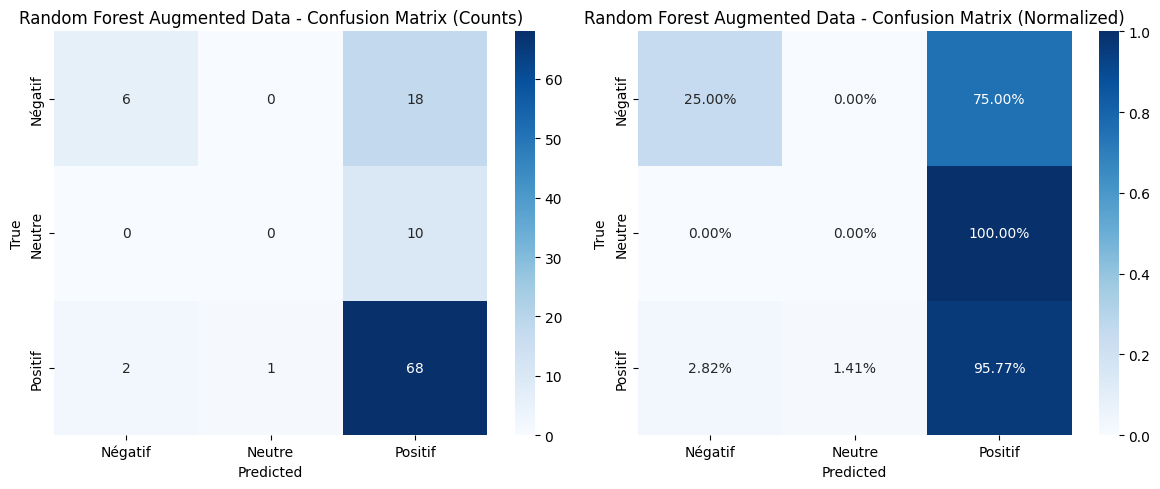

Model saved to: ../models/ml_classic_models\randomforestaugmenteddata

5-FOLD CROSS VALIDATION (Random Forest Augmented Data)
  Fold 1: Accuracy = 0.7769
  Fold 2: Accuracy = 0.7752
  Fold 3: Accuracy = 0.7907
  Fold 4: Accuracy = 0.8372
  Fold 5: Accuracy = 0.8372

CROSS-VALIDATION SUMMARY (Random Forest Augmented Data)
  Mean Accuracy: 0.8034 (±0.0281)
  Négatif: Precision=0.9290 ±0.0295, Recall=0.6700 ±0.0177, F1=0.7781 ±0.0149
  Neutre: Precision=1.0000 ±0.0000, Recall=0.7395 ±0.0848, F1=0.8475 ±0.0566
  Positif: Precision=0.6814 ±0.0351, Recall=0.9572 ±0.0193, F1=0.7954 ±0.0241

SAMPLE TESTING (Random Forest Augmented Data):
Text                                          Prediction   Confidence
Très mauvais gym, équipements sales 😠         Positif      0.565     
C'était correct, rien d'exceptionnel          Positif      0.577     
Super salle, coaches très sympa 👍⭐            Positif      0.685     
Pas terrible, je ne recommande pas            Positif      0.560     
Moyen, ni bo

In [9]:
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42))
])

# Train & evaluate
#rf_model, rf_pred = evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest")
rf_model, rf_pred = evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest Augmented Data")

# Save model
#rf_model_path = save_model(rf_model, "RandomForest")
rf_model_path = save_model(rf_model, "RandomForestAugmentedData")

# Cross-validation
#cross_validate_model(rf_pipeline, X_train, y_train, "Random Forest", cv_folds=5)
cross_validate_model(rf_pipeline, X_train, y_train, "Random Forest Augmented Data", cv_folds=5)

# Sample testing
#test_samples(rf_pipeline, SAMPLES, "Random Forest")
test_samples(rf_pipeline, SAMPLES, "Random Forest Augmented Data")

In [10]:
if os.path.exists(RESULTS_PATH):
    with open(RESULTS_PATH, 'r', encoding='utf-8') as f:
        results = json.load(f)
else:
    results = {
        'data_info': {
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'class_distribution': dict(zip(LABEL_NAMES.values(), np.bincount(y_train).tolist()))
        },
        'models': {}
    }

#results['models']['RandomForest'] = {
results['models']['RandomForestAugmentedData'] = {
    'accuracy': float(accuracy_score(y_test, rf_pred)),
    'weighted_f1': float(f1_score(y_test, rf_pred, average='weighted', zero_division=0)),
    'macro_f1': float(f1_score(y_test, rf_pred, average='macro', zero_division=0)),
    'per_class_f1': {
        label_name: float(f1_score(y_test == label_id, rf_pred == label_id, zero_division=0))
        for label_id, label_name in LABEL_NAMES.items()
    }
}

with open(RESULTS_PATH, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"Random Forest results appended to: {RESULTS_PATH}")

Random Forest results appended to: ../models/comparison_summary.json
